# 1. Configuración de la sesión Spark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("OrderLinesBatchProcessing") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .getOrCreate()


print("✅ Spark Session creada")
print(f"Versión de Spark: {spark.version}")

✅ Spark Session creada
Versión de Spark: 3.5.0


# 2. Lectura de Datos (Filtro por Partición)

In [6]:
path = "s3a://temperature-sensors/"

df = spark.read.json(path)

# Mostrar esquema para verificar que los datos llegan bien
df.printSchema()
df.show(5)

root
 |-- location: string (nullable = true)
 |-- sensor_id: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)

+-----------+---------+-----------+--------------------+----+-----+---+----+
|   location|sensor_id|temperature|           timestamp|year|month|day|hour|
+-----------+---------+-----------+--------------------+----+-----+---+----+
|Warehouse_A|  TEMP_01|      20.08|2025-02-13T00:00:...|2026|    2| 19|  18|
|Warehouse_A|  TEMP_01|      20.12|2025-02-13T00:10:...|2026|    2| 19|  18|
|Warehouse_A|  TEMP_01|      20.25|2025-02-13T00:20:...|2026|    2| 19|  18|
|Warehouse_B|  TEMP_02|      17.95|2025-02-13T00:20:...|2026|    2| 19|  18|
|Warehouse_A|  TEMP_01|      20.34|2025-02-13T00:30:...|2026|    2| 19|  18|
+-----------+---------+-----------+--------------------+----+----

# 3. Cálculo de Métricas por Sensor

In [7]:
metrics_df = df.groupBy("sensor_id").agg(
    avg("temperature").alias("temp_promedio"),
    min("temperature").alias("temp_minima"),
    max("temperature").alias("temp_maxima")
)

metrics_df.show()

+---------+------------------+-----------+-----------+
|sensor_id|     temp_promedio|temp_minima|temp_maxima|
+---------+------------------+-----------+-----------+
|  TEMP_02|21.850547945205477|       16.7|      27.26|
|  TEMP_01|47.330106544901064|      20.08|      74.65|
+---------+------------------+-----------+-----------+



# 4. Visualización de la Tendencia

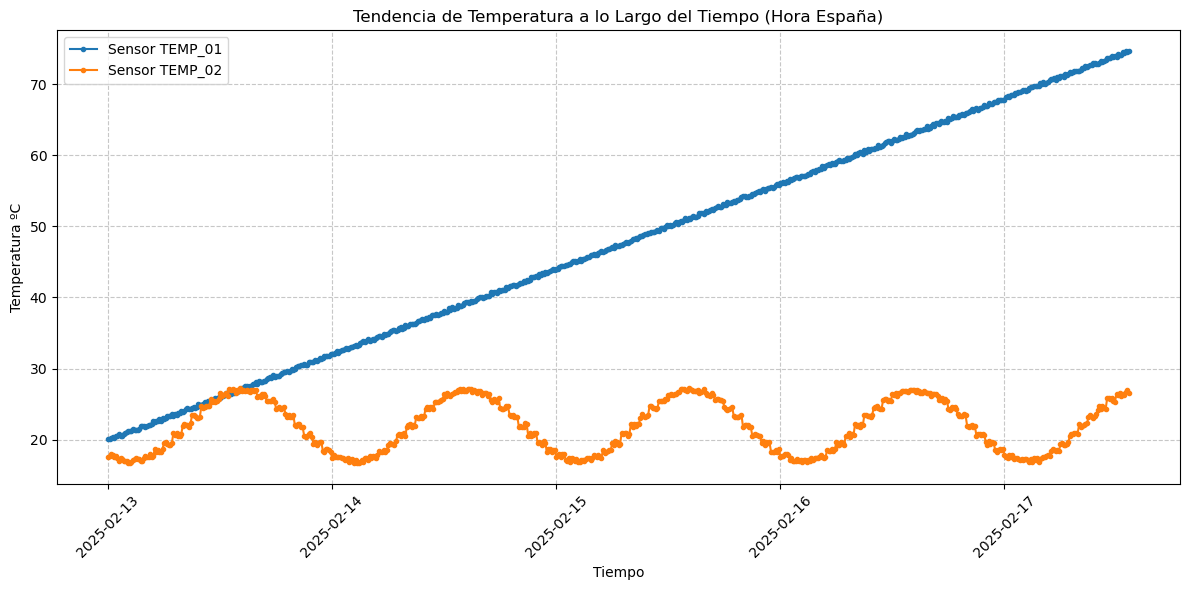

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convertimos a Pandas para graficar
pdf = df.select("timestamp", "temperature", "sensor_id").orderBy("timestamp").toPandas()

# 2. Convertir string a objeto datetime 
pdf['timestamp'] = pd.to_datetime(pdf['timestamp'])

# 3. Configuración del gráfico
plt.figure(figsize=(12, 6))

# Iteramos por cada sensor para dibujar su línea
for sensor in pdf['sensor_id'].unique():
    subset = pdf[pdf['sensor_id'] == sensor]
    plt.plot(subset['timestamp'], subset['temperature'], label=f'Sensor {sensor}', marker='.')

plt.title("Tendencia de Temperatura a lo Largo del Tiempo (Hora España)")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura ºC")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()